In [2]:

# This must be the path to the folder in which the project directory is located
project_dir = '/Users/jonathannicholas/gradschool/manuscripts'

# Set this if the neuropsych data has been scored
# This has to happen manually!
ns_scored = True

from __future__ import division
import glob, os, sys, subprocess, ast, warnings, importlib, pickle
sys.path.append(os.path.join(project_dir,'ataxia-rl/code/scripts'))
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib import patches
from scipy.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
import seaborn as sns
import arviz as az
from scipy.stats import beta
import preprocess_data
import support_functions
from support_functions import get_reversal_df

paper_dir = os.path.join(project_dir,"ataxia-rl")
data_dir = os.path.join(project_dir,"ataxia-rl/data")
palette = ["#8da0cb","#66c2a5"]
diag_palette = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3","#a6d854"]
sns.set_context("poster")
sns.set_palette(palette)
sns.set(style="ticks",font="Arial",font_scale=2)

In [3]:
'''
  This chunk loads the data and models and performs all processing for the RESPONSE MAPPING task.
  Will run most scripts if output files are not found (except for model fitting)
'''

#Process the raw response mapping task data
rm_d_files = ["patientMapData4Stan.csv","controlMapData4Stan.csv"]
groups = ["patient","control"]
rm_data = {}
for grp in groups:
  if os.path.isfile(os.path.join(data_dir,"%sMapData4Stan.csv"%grp)):
    rm_data[grp] = pd.read_csv(os.path.join(data_dir,"%sMapData4Stan.csv"%grp))
  else:
    rm_data[grp] = preprocess_data.process(1,data_dir,grp)
rm_data_full = pd.concat([rm_data["patient"],rm_data["control"]]).reset_index(drop=True)
rm_data_full.to_csv(os.path.join(data_dir,"combinedMapData4Stan.csv"))

# Process the neuropsych data for controls
if ns_scored == False:
  # Extract the ccas data to a format for easier scoring
  preprocess_data.processCCAS(data_dir,rm_data["control"])
  raise ValueError("Control Neuropsychs need to be score manually before proceeding.") #TODO: Make sure this works!
else:
  scored_ccas = pd.read_csv(os.path.join(data_dir,"ccasRmScored.csv"))
  ctrl_pat_map = pd.read_csv(os.path.join(data_dir,"ctrl_pat_map.csv"))
  ctrl_patient_id_ccas = []
  for i, row in scored_ccas[scored_ccas.group == "CTRL"].iterrows():
    ctrl_patient_id_ccas.append(ctrl_pat_map[ctrl_pat_map.control == row.subject_id]["patient"].iloc[0])
  ctrl_patient_id_ccas.extend(list(scored_ccas[scored_ccas.group == "PAT"].subject_id))
  scored_ccas["ctrl_patient_id"] = ctrl_patient_id_ccas
  scored_ccas.to_csv(os.path.join(data_dir,"ccasRmScored.csv"))

# Run the ideal observer on the patient data
if os.path.isfile(os.path.join(data_dir,"idealMapData4Stan.csv")):
  rm_data["ideal"] = pd.read_csv(os.path.join(data_dir,"idealMapData4Stan.csv"))
else:
  rm_data["ideal"] = support_functions.runRMIdealObserver(rm_data["patient"],data_dir)
# Create a factorized patient subject id for all datasets
rm_data["patient"]["patient_factor"] = pd.factorize(rm_data["patient"].subject_id)[0].astype("int")+1
rm_data["control"]["patient_factor"] = pd.factorize(rm_data["control"].ctrl_patient_id)[0].astype("int")+1
rm_data["ideal"]["patient_factor"] = pd.factorize(rm_data["ideal"].sub_factor)[0].astype("int")+1

# Create variables and dataframes for plotting and further analysis
rm_data["patient"]["accuracy"] = rm_data["patient"].apply(lambda row: preprocess_data.code_correct_choice(row), axis=1)
rm_data["control"]["accuracy"] = rm_data["control"].apply(lambda row: preprocess_data.code_correct_choice(row), axis=1)
rm_data["ideal"]["accuracy"] = rm_data["ideal"].apply(lambda row: preprocess_data.code_correct_choice(row), axis=1)
# Add each patient's diagnosis to the dataframe
pat_diags = ctrl_pat_map[["patient","diagnosis_full","diagnosis_short"]].drop_duplicates().reset_index(drop=True)
pat_diags["subject_id"] = pat_diags["patient"]
rm_data["patient"] = rm_data["patient"].merge(pat_diags[["subject_id","diagnosis_full","diagnosis_short"]],on="subject_id")

n_bins = 20
rm_data["patient"]["trial_binned"] = pd.cut(rm_data["patient"].trial_number,n_bins,labels=range(0,n_bins))
rm_data["control"]["trial_binned"] = pd.cut(rm_data["control"].trial_number,n_bins,labels=range(0,n_bins))
rm_data["ideal"]["trial_binned"] = pd.cut(rm_data["ideal"].trial_number,n_bins,labels=range(0,n_bins))
acc_df = {"accuracy":[i for j in [rm_data["patient"]["accuracy"],rm_data["control"]["accuracy"],rm_data["ideal"]["accuracy"]] for i in j],
          "group":[i for j in [["Patients"]*len(rm_data["patient"]),["Controls"]*len(rm_data["control"]),["Ideal Obs"]*len(rm_data["ideal"])] for i in j],
          "subject_id":[i for j in [rm_data["patient"]["subject_id"],rm_data["control"]["subject_id"],rm_data["ideal"]["sub_factor"]] for i in j],}
acc_df = pd.DataFrame.from_dict(acc_df)

# Load fit model parameters and loo performance

last_file = os.path.join(paper_dir,"code/fit_models/rm/summarized/sensitivity2_stat_effects.csv")
if os.path.isfile(last_file) == False:
  rscript = "sprintf('%s/code/scripts/loadRMapModels.rmd')"%paper_dir
  rparams = "list(basedir='%s')"%(paper_dir)
  routfile = "sprintf('rmap_load_results.html')"
  routdir = "sprintf('%s/code/reports/')"%(paper_dir)
  cmd = 'Rscript -e "rmarkdown::render(%s,params = %s,output_file = %s,output_dir = %s)"'%(rscript,rparams,routfile,routdir)
  subprocess.call(cmd, shell=True)

rm_elpd_diffs = pd.read_csv(os.path.join(paper_dir,"code/fit_models/rm/summarized/rm_elpd_diffs.csv"))
pat_elpds = rm_elpd_diffs[rm_elpd_diffs.group == "PAT"]
pat_elpds["patient"] = pat_elpds.subject_id.astype("int")
pat_elpds = pat_elpds.merge(pat_diags[["patient","diagnosis_short"]],on="patient")

pat_rm_rands = pd.read_csv(os.path.join(paper_dir,"code/fit_models/rm/summarized/patient_random_model_params.csv"))
ctrl_rm_rands = pd.read_csv(os.path.join(paper_dir,"code/fit_models/rm/summarized/ctrl_random_model_params.csv"))
pat_rm_rws = pd.read_csv(os.path.join(paper_dir,"code/fit_models/rm/summarized/patient_rw_model_params.csv"))
ctrl_rm_rws = pd.read_csv(os.path.join(paper_dir,"code/fit_models/rm/summarized/ctrl_rw_model_params.csv"))

# Add posterior predictives to task dataframes
rm_data["patient"]["rand_post_pred"] = np.array(pat_rm_rands[~pat_rm_rands.param.isin(["beta[1]","beta[2]"])]["mean"])
rm_data["patient"]["rw_post_pred"] = np.array(pat_rm_rws[~pat_rm_rws.param.isin(["beta[1]","beta[2]","beta[3]","beta[4]","alpha"])]["mean"])
rm_data["control"]["rand_post_pred"] = np.array(ctrl_rm_rands[~ctrl_rm_rands.param.isin(["beta[1]","beta[2]"])]["mean"])
rm_data["control"]["rw_post_pred"] = np.array(ctrl_rm_rws[~ctrl_rm_rws.param.isin(["beta[1]","beta[2]","beta[3]","beta[4]","alpha"])]["mean"])
rm_data["patient"]["rand_pp_choice"] = (rm_data["patient"].rand_post_pred >= 0.5).replace({True:1,False:0})
rm_data["patient"]["rw_pp_choice"] = (rm_data["patient"].rw_post_pred >= 0.5).replace({True:1,False:0})
rm_data["control"]["rand_pp_choice"] = (rm_data["control"].rand_post_pred >= 0.5).replace({True:1,False:0})
rm_data["control"]["rw_pp_choice"] = (rm_data["control"].rw_post_pred >= 0.5).replace({True:1,False:0})

rm_reg_file_names = ["alpha","bias1","bias2","sensitivity1","sensitivity2","acc","dsbwd","dsfwd","elpd"]
rm_effects = dict((n,0) for n in rm_reg_file_names)

# Run stats on model-free behavior

# Save a dataframe with combined data and columns for statistical comparison
cols = ["subject_id","sub_factor","patient_factor","trial_number","trial_binned","accuracy","group","pFReward1","rt"]
rmData4Stats = pd.concat([rm_data["patient"][cols],rm_data["control"][cols]]).reset_index(drop=True)
rmData4Stats["group_coded"] = rmData4Stats["group"].replace({1:0.5,2:-0.5})
rmData4Stats.to_csv(os.path.join(data_dir,"rm/rmData4Stats.csv"))

# Run stats (note this takes a while because of the mixed effects polynomial logistic regression)
last_file = os.path.join(paper_dir,"code/fit_models/rm/summarized/elpd_stat_effects.csv")
if os.path.isfile(last_file) == False:
  rscript = "sprintf('%s/code/scripts/runRMapStats.rmd')"%paper_dir
  rparams = "list(basedir='%s')"%(paper_dir)
  routfile = "sprintf('rmap_load_results.html')"
  routdir = "sprintf('%s/code/reports/')"%(paper_dir)
  cmd = 'Rscript -e "rmarkdown::render(%s,params = %s,output_file = %s,output_dir = %s)"'%(rscript,rparams,routfile,routdir)
  subprocess.call(cmd, shell=True)

def format_effects(row,stan=False):
  if stan:
    return " = %s,\:95\%%\:CI = [%s,\:%s]"%(np.round(float(row["mean"]),3),
                                            np.round(float(row["2.5%"]),3),
                                            np.round(float(row["97.5%"]),3))
  else:
    return " = %s,\:95\%%\:CI = [%s,\:%s]"%(np.round(float(row["mean"]),3),
                                            np.round(float(row["X2.5."]),3),
                                            np.round(float(row["X97.5."]),3))

for effect in rm_reg_file_names:
  feff_file = os.path.join(paper_dir,"code/fit_models/rm/summarized/%s_stat_effects.csv"%effect)
  feff = pd.read_csv(feff_file)
  feff["report"] = feff.apply(lambda row: format_effects(row), axis=1)
  feff.index = feff.effect
  rm_effects[effect] = feff


In [6]:

'''
  This chunk loads the data and models and performs all processing for the CARD LEARNING task.
  Will run most scripts if output files are not found (except for model fitting)
'''

card_data = {}
card_data["control"] = preprocess_data.process(2,data_dir,"control")
# exclude subject who responded red for all but 2 trials
card_data["control"] = card_data["control"][card_data["control"].subject_id != "A2OQMY85Q2WY68"]
card_data["patient"] = preprocess_data.process(2,data_dir,"patient")
card_data["patient"].to_csv(os.path.join(data_dir,"patientHybridData4Stan.csv"),index=False)
card_data["ideal"] = pd.read_csv(os.path.join(project_dir,"ataxia-rl/code/scripts/in_progress/idealSimHybridData.csv"))
card_data["ideal"]["ctrl_patient_id"] = 'none'
card_data["ideal"]["subject_id"] = card_data["ideal"]["sub_factor"]
card_data["control"]["old_trial"] = card_data["control"].old_deck.replace({0.5:1,-0.5:1})
card_data["patient"]["old_trial"] = card_data["patient"].old_deck.replace({0.5:1,-0.5:1})
true_deck_val = pd.concat([card_data["control"][card_data["control"].lucky_chosen==0].groupby(["subject_id"]).outcome.rolling(1000,min_periods=0).mean().reset_index(name="true_deck_value"),
                           card_data["control"][card_data["control"].lucky_chosen==1].groupby(["subject_id"]).outcome.rolling(1000,min_periods=0).mean().reset_index(name="true_deck_value")]).sort_values(by="level_1")
card_data["control"]["true_deck_value"] = np.array(true_deck_val["true_deck_value"])
true_deck_val = pd.concat([card_data["patient"][card_data["patient"].lucky_chosen==0].groupby(["subject_id"]).outcome.rolling(1000,min_periods=0).mean().reset_index(name="true_deck_value"),
                           card_data["patient"][card_data["patient"].lucky_chosen==1].groupby(["subject_id"]).outcome.rolling(1000,min_periods=0).mean().reset_index(name="true_deck_value")]).sort_values(by="level_1")
card_data["patient"]["true_deck_value"] = np.array(true_deck_val["true_deck_value"])

# Get data centered around reversal trials
lrd_pat = get_reversal_df(n_around=4,data=card_data["patient"],ys=["lucky_chosen","rt"])
lrd_pat["time_point2"] = lrd_pat.time_point.replace({-4:"m4",-3:"m3",-2:"m2",-1:"m1"})
lrd_ctrl = get_reversal_df(n_around=4,data=card_data["control"],ys=["lucky_chosen","rt"])
lrd_ctrl["time_point2"] = lrd_ctrl.time_point.replace({-4:"m4",-3:"m3",-2:"m2",-1:"m1"})
lrd_ideal = get_reversal_df(n_around=4,data=card_data["ideal"],ys=["lucky_chosen"])
lrd_ideal["time_point2"] = lrd_ideal.time_point.replace({-4:"m4",-3:"m3",-2:"m2",-1:"m1"})

pat_od = card_data["patient"][(card_data["patient"].should_choose_old.notnull())]
ctrl_od = card_data["control"][(card_data["control"].should_choose_old.notnull())]
ideal_od = card_data["ideal"][card_data["ideal"].old_trial==True]

# Load Hybrid Task Subsequent memory data
pat_mem_data = pd.read_csv(os.path.join(data_dir,"hybrid","patient_hyb_mem_data.csv"))
pat_mem_data["response_type"] = pat_mem_data.apply(lambda row: preprocess_data.pat_signal_detect(row),axis=1)
dprime_df = pat_mem_data.groupby(["SubNum","response_type"]).size().unstack(fill_value=0).stack().reset_index(name="n_responses")
pat_dprimes = {"subject_id":[],"dprime":[]}
for s in dprime_df.SubNum.unique():
  sd = dprime_df[dprime_df.SubNum == s]
  dprime = preprocess_data.compute_dprime(n_Hit=sd[sd.response_type == "hit"].n_responses.iloc[0],
                                          n_Miss=sd[sd.response_type == "miss"].n_responses.iloc[0],
                                          n_FA=sd[sd.response_type == "fa"].n_responses.iloc[0],
                                          n_CR=sd[sd.response_type == "cr"].n_responses.iloc[0])
  pat_dprimes["subject_id"].append(s)
  pat_dprimes["dprime"].append(dprime)
pat_dprimes = pd.DataFrame.from_dict(pat_dprimes)
pat_dprimes["group"] = "PAT"

n_subs, orig_ctrl_data = preprocess_data.load_mturk_data(data_dir=os.path.join(data_dir,"hybrid/control"))
ctrl_mem_data = orig_ctrl_data[orig_ctrl_data.phase.isin(["recognition_mem","choice_mem","value_mem"])]#.phase.unique()
recog_data = ctrl_mem_data[ctrl_mem_data.phase == "recognition_mem"]
recog_data['response_type'] = recog_data.apply(lambda row: preprocess_data.ctrl_signal_detect(row),axis=1)
sdt_data = recog_data.groupby(["subject_id","response_type"]).size().unstack(fill_value=0).stack().reset_index(name="n_responses")
ctrl_dprimes = {'subject_id':[],'dprime':[]}
for subj in sdt_data.subject_id.unique():
    subj_data = sdt_data[sdt_data.subject_id == subj]
    dprime = preprocess_data.compute_dprime(n_Hit=subj_data[subj_data.response_type == "hit"].n_responses.iloc[0],
                                            n_Miss=subj_data[subj_data.response_type == "miss"].n_responses.iloc[0],
                                            n_FA=subj_data[subj_data.response_type == "fa"].n_responses.iloc[0],
                                            n_CR=subj_data[subj_data.response_type == "cr"].n_responses.iloc[0])
    ctrl_dprimes['subject_id'].append(subj)
    ctrl_dprimes['dprime'].append(dprime)
ctrl_dprimes = pd.DataFrame.from_dict(ctrl_dprimes)
ctrl_dprimes = ctrl_dprimes[ctrl_dprimes.subject_id != "A2OQMY85Q2WY68"]
ctrl_dprimes["group"] = "CTRL"

dprimes = pd.concat([pat_dprimes,ctrl_dprimes])

# Load fit model parameters and loo performance
last_file = os.path.join(paper_dir,"code/fit_models/hybrid/summarized/oldsensitivity_stat_effects.csv")
if os.path.isfile(last_file) == False:
  rscript = "sprintf('%s/code/scripts/loadHybridModels.rmd')"%paper_dir
  rparams = "list(basedir='%s')"%(paper_dir)
  routfile = "sprintf('hybrid_load_results.html')"
  routdir = "sprintf('%s/code/reports/')"%(paper_dir)
  cmd = 'Rscript -e "rmarkdown::render(%s,params = %s,output_file = %s,output_dir = %s)"'%(rscript,rparams,routfile,routdir)
  subprocess.call(cmd, shell=True)

hybrid_elpd_diffs = pd.read_csv(os.path.join(paper_dir,"code/fit_models/hybrid/summarized/hybrid_elpd_diffs.csv"))
full_hybrid_rws = pd.read_csv(os.path.join(paper_dir,"code/fit_models/hybrid/summarized/full_hybrid_rw_model_params.csv"))

pat_hybrid_rands = pd.read_csv(os.path.join(paper_dir,"code/fit_models/hybrid/summarized/patient_random_model_params.csv"))
ctrl_hybrid_rands = pd.read_csv(os.path.join(paper_dir,"code/fit_models/hybrid/summarized/ctrl_random_model_params.csv"))
pat_hybrid_rws = pd.read_csv(os.path.join(paper_dir,"code/fit_models/hybrid/summarized/patient_rw_model_params.csv"))
ctrl_hybrid_rws = pd.read_csv(os.path.join(paper_dir,"code/fit_models/hybrid/summarized/ctrl_rw_model_params.csv"))

# Add posterior predictives to task dataframes
card_data["patient"]["rand_post_pred"] = np.array(pat_hybrid_rands[~pat_hybrid_rands.param.isin(["beta"])]["mean"])
card_data["patient"]["rw_post_pred"] = np.array(pat_hybrid_rws[~pat_hybrid_rws.param.isin(["beta[1]","beta[2]","beta[3]","beta[4]","alpha"])]["mean"])
card_data["control"]["rand_post_pred"] = np.array(ctrl_hybrid_rands[~ctrl_hybrid_rands.param.isin(["beta"])]["mean"])
card_data["control"]["rw_post_pred"] = np.array(ctrl_hybrid_rws[~ctrl_hybrid_rws.param.isin(["beta[1]","beta[2]","beta[3]","beta[4]","alpha"])]["mean"])
card_data["patient"]["rand_pp_choice"] = (card_data["patient"].rand_post_pred >= 0.5).replace({True:1,False:0})
card_data["patient"]["rw_pp_choice"] = (card_data["patient"].rw_post_pred >= 0.5).replace({True:1,False:0})
card_data["control"]["rand_pp_choice"] = (card_data["control"].rand_post_pred >= 0.5).replace({True:1,False:0})
card_data["control"]["rw_pp_choice"] = (card_data["control"].rw_post_pred >= 0.5).replace({True:1,False:0})
card_data['patient']["red_chosen2"] = card_data['patient']["red_chosen"]-1
card_data['control']["red_chosen2"] = card_data['control']["red_chosen"]-1

hybrid_reg_file_names = ["alpha","decksensitivity","oldbias","oldsensitivity",
                         "decksensitivity_PAT","decksensitivity_CTRL",
                         "oldbias_PAT","oldbias_CTRL",
                         "oldsensitivity_PAT","oldsensitivity_CTRL",
                         "dprime","lrd","elpd"]
hybrid_effects = dict((n,0) for n in hybrid_reg_file_names)

# Run stats on model-free behavior

# Save out datasets for stats
lrd_pat["group_coded"] = -0.5
lrd_ctrl["group_coded"] = 0.5
lrd4stats = pd.concat([lrd_pat,lrd_ctrl]).reset_index(drop=True)
lrd4stats = pd.concat([lrd4stats,pd.get_dummies(lrd4stats["time_point2"], prefix="t")],axis=1)
lrd4stats = lrd4stats.drop("time_point2",axis=1)
dprimes = dprimes.merge(lrd4stats.groupby(["subject_id","ctrl_patient_id"]).size().reset_index(name="count").drop("count",axis=1),on="subject_id")
dprimes["group_coded"] = dprimes["group"].replace({"PAT":-0.5,"CTRL":0.5})
lrd4stats.to_csv(os.path.join(data_dir,"hybrid","lrdData4Stats.csv"))
dprimes.to_csv(os.path.join(data_dir,"hybrid","dprimeData4Stats.csv"))

# need to get this actually right, and then load the stats in!
# Run stats (note this takes a while because of the mixed effects logistic regressions)
last_file = os.path.join(paper_dir,"code/fit_models/hybrid/summarized/elpd_stat_effects.csv")
if os.path.isfile(last_file) == False:
  rscript = "sprintf('%s/code/scripts/runHybridStats.rmd')"%paper_dir
  rparams = "list(basedir='%s')"%(paper_dir)
  routfile = "sprintf('rmap_load_results.html')"
  routdir = "sprintf('%s/code/reports/')"%(paper_dir)
  cmd = 'Rscript -e "rmarkdown::render(%s,params = %s,output_file = %s,output_dir = %s)"'%(rscript,rparams,routfile,routdir)
  subprocess.call(cmd, shell=True)

for effect in hybrid_reg_file_names:
  feff_file = os.path.join(paper_dir,"code/fit_models/hybrid/summarized/%s_stat_effects.csv"%effect)
  feff = pd.read_csv(feff_file)
  feff["report"] = feff.apply(lambda row: format_effects(row), axis=1)
  feff.index = feff.effect
  hybrid_effects[effect] = feff


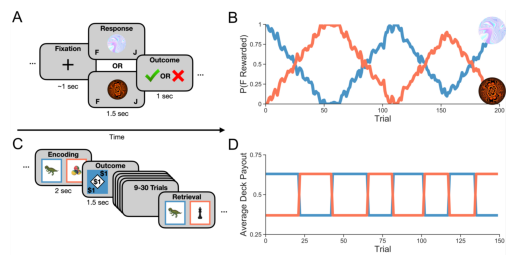

In [7]:
'''
  Load the task figure
'''

img = mpimg.imread(os.path.join(paper_dir,'code/figures/figure1.png'))
fig = plt.imshow(img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.axis('off')
plt.show();

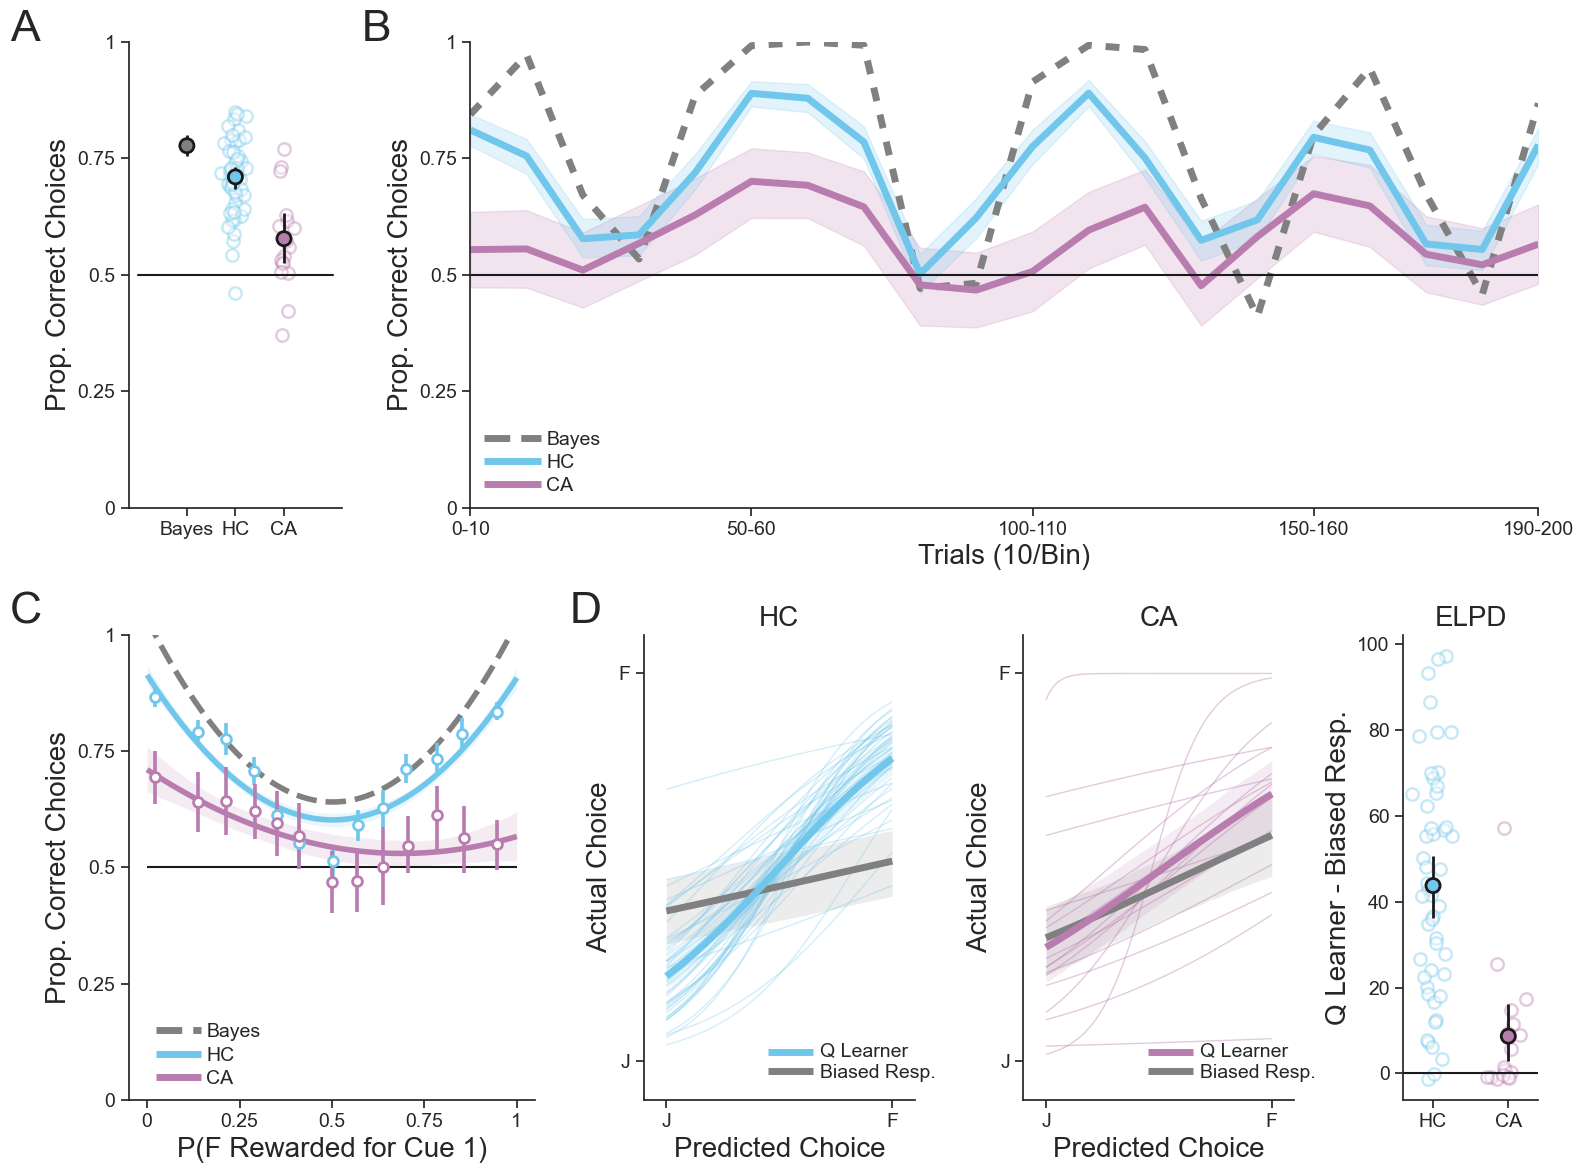

In [ ]:
palette = ["#b97caf","#71c7eb"]

fig2 = plt.figure(figsize=(16,12),constrained_layout=True)
gs = fig2.add_gridspec(2,1)

gs0 = gs[0].subgridspec(1,2,width_ratios=[1,5],wspace=0.2)
ax1 = fig2.add_subplot(gs0[0,1])
ax2 = fig2.add_subplot(gs0[0,0])

gs1 = gs[1].subgridspec(1,4,width_ratios=[6,4,4,2],wspace=0.4)
ax3 = fig2.add_subplot(gs1[0,0])
ax4 = fig2.add_subplot(gs1[0,1])
ax5 = fig2.add_subplot(gs1[0,2])
ax6 = fig2.add_subplot(gs1[0,3])


plt.gcf().text(0, 0.965, "A", fontsize=32)
plt.gcf().text(0.22, 0.965, "B", fontsize=32)
plt.gcf().text(0, 0.48, "C", fontsize=32)
plt.gcf().text(0.35, 0.48, "D", fontsize=32)


# AVERAGE ACCURACY (COLLAPSED)
ax = ax2
ctrl_means = np.array(acc_df[acc_df.group == "Controls"].groupby(["subject_id"]).mean().reset_index()["accuracy"])
pat_means = np.array(acc_df[acc_df.group == "Patients"].groupby(["subject_id"]).mean().reset_index()["accuracy"])

with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  sns.pointplot(x="group",y="accuracy",data=acc_df,join=False,units="subject_id",
                color='k',ax=ax,scale=1.5,errwidth=2,order=["Ideal Obs","Controls","Patients"])
  plt.setp(ax.collections, facecolor=["gray",palette[1],palette[0]],zorder=100,linewidth=2)
  ax.scatter(np.random.normal(2,0.1,len(pat_means)),pat_means,color=palette[0],s=80,facecolor="w",zorder=0,linewidth=1.75,alpha=0.4)
  ax.scatter(np.random.normal(1,0.1,len(ctrl_means)),ctrl_means,color=palette[1],s=80,facecolor="w",zorder=0,linewidth=1.75,alpha=0.4)

ax.set_ylim(0,1)
ax.set_ylabel("Prop. Correct Choices",size=20)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,0.25,0.5,0.75,1],size=14)
ax.set_xlabel("",size=20)
ax.set_xticklabels(["Bayes","HC","CA"],size=14)
ax.plot((-1,3),(0.5,0.5),'k')

# AVERAGE ACCURACY (BY TRIAL BIN)
ax = ax1
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  sns.lineplot(x="trial_binned",y="accuracy",data=rm_data["ideal"],color="gray",
               ax=ax,linewidth=5,ci=None,style=True, dashes=[(2,2)], legend=False)
  sns.lineplot(x="trial_binned",y="accuracy",data=rm_data["patient"],color=palette[0],ax=ax,linewidth=5)
  sns.lineplot(x="trial_binned",y="accuracy",data=rm_data["control"],color=palette[1],ax=ax,linewidth=5)
  ax.set_ylim(0,1)
  ax.set_ylabel("Prop. Correct Choices",size=20)
  ax.set_yticks([0,0.25,0.5,0.75,1])
  ax.set_yticklabels([0,0.25,0.5,0.75,1],size=14)
  ax.set_xticks([0,5,10,15,19])
  ax.set_xlim(0,19)
  ax.set_xticklabels(["0-10","50-60","100-110","150-160","190-200"],size=14)
  ax.set_xlabel("Trials (10/Bin)",size=20)
  ax.plot((-1,19),(0.5,0.5),'k')
  # Create a legend by hand
  ax.plot((0.25,1.25),(0.15,0.15),"gray",linewidth=5,linestyle="--")
  ax.plot((0.25,1.25),(0.1,0.1),palette[1],linewidth=5)
  ax.plot((0.25,1.25),(0.05,0.05),palette[0],linewidth=5)
  ax.text(1.35,0.135,'Bayes',fontsize=14)
  ax.text(1.35,0.085,'HC',fontsize=14)
  ax.text(1.35,0.035,'CA',fontsize=14)

ax = ax3
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((0,1),(0.5,0.5),'k')
  sns.regplot(x="pFReward1",y="accuracy",data=rm_data['ideal'],ax=ax,order=2,color='gray',marker="",ci=None,line_kws={"linestyle":"--","linewidth":4})
  sns.regplot(x="pFReward1",y="accuracy",data=rm_data['control'],ax=ax,x_bins=13,order=2,color=palette[1],line_kws={"linewidth":4})
  sns.regplot(x="pFReward1",y="accuracy",data=rm_data['patient'],ax=ax,x_bins=13,order=2,color=palette[0],line_kws={"linewidth":4})
  # Create a legend by hand
  ax.plot((0.025,0.145),(0.15,0.15),"gray",linewidth=5,linestyle="--")
  ax.plot((0.025,0.145),(0.1,0.1),palette[1],linewidth=5)
  ax.plot((0.025,0.145),(0.05,0.05),palette[0],linewidth=5)
  ax.text(0.16,0.135,'Bayes',fontsize=14)
  ax.text(0.16,0.085,'HC',fontsize=14)
  ax.text(0.16,0.035,'CA',fontsize=14)
plt.setp(ax.collections[3], facecolor="w",zorder=100,alpha=1,linewidth=2)
plt.setp(ax.collections[1], facecolor="w",zorder=100,alpha=1,linewidth=2)
ax.set_ylabel("Prop. Correct Choices",size=20)
ax.set_xlabel("P(F Rewarded for Cue 1)",size=20)
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_xticklabels([0,0.25,0.5,0.75,1],size=14)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,0.25,0.5,0.75,1],size=14)
ax.set_ylim(0,1)

#ax4, ax5
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  for s in rm_data['patient'].sub_factor.unique():
    sns.regplot(y="rw_pp_choice",x="f_chosen",data=rm_data['patient'][rm_data['patient'].sub_factor == s],
                logistic=True,ci=None,color=palette[0],ax=ax5,line_kws={"linewidth":"1","alpha":0.4},marker="")
  sns.regplot(y="rand_pp_choice",x="f_chosen",data=rm_data['patient'],logistic=True,color="gray",
              units="sub_factor",ax=ax5,line_kws={"linewidth":"5"},marker="")
  sns.regplot(y="rw_pp_choice",x="f_chosen",data=rm_data['patient'],logistic=True,color=palette[0],
              units="sub_factor",ax=ax5,line_kws={"linewidth":"5"},marker="")
  for s in rm_data['control'].sub_factor.unique():
    sns.regplot(y="rw_pp_choice",x="f_chosen",data=rm_data['control'][rm_data['control'].sub_factor == s],
                logistic=True,ci=None,color=palette[1],ax=ax4,line_kws={"linewidth":"1","alpha":0.3},marker="")
  sns.regplot(y="rand_pp_choice",x="f_chosen",data=rm_data['control'],logistic=True,color="gray",
              units="sub_factor",ax=ax4,line_kws={"linewidth":"5"},marker="")
  sns.regplot(y="rw_pp_choice",x="f_chosen",data=rm_data['control'],logistic=True,color=palette[1],
              units="sub_factor",ax=ax4,line_kws={"linewidth":"5"},marker="")
  ax4.plot((0.45,0.65),(0.025,0.025),palette[1],linewidth=5)
  ax4.plot((0.45,0.65),(-0.025,-0.025),"gray",linewidth=5)
  ax4.text(0.68,0.0125,'Q Learner',fontsize=14)
  ax4.text(0.68,-0.0425,'Biased Resp.',fontsize=14)

  ax5.plot((0.45,0.65),(0.025,0.025),palette[0],linewidth=5)
  ax5.plot((0.45,0.65),(-0.025,-0.025),"gray",linewidth=5)
  ax5.text(0.68,0.0125,'Q Learner',fontsize=14)
  ax5.text(0.68,-0.0425,'Biased Resp.',fontsize=14)

titles = ["HC","CA"]
for i, a in enumerate([ax4,ax5]):
  a.set_ylim(0,1)
  a.set_xlim(0,1)
  a.set_ylabel("Actual Choice",size=20)
  a.set_xlabel("Predicted Choice",size=20)
  a.set_title(titles[i],size=20)
  a.set_xticks([0,1])
  a.set_yticks([0,1])
  a.set_xticklabels(["J","F"],size=14)
  a.set_yticklabels(["J","F"],size=14)
  a.set_xlim(-0.1,1.1)
  a.set_ylim(-0.1,1.1)

ax = ax6
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  sns.pointplot(x="group",y="elpd_diff",data=rm_elpd_diffs,join=False,units="subject_id",
                color='k',ax=ax,scale=1.5,errwidth=2,order=["CTRL","PAT"])
  plt.setp(ax.collections, facecolor=[palette[1],palette[0]],zorder=100,linewidth=2)
ax.scatter(np.random.normal(0,0.1,len(rm_elpd_diffs[rm_elpd_diffs.group == "CTRL"])),rm_elpd_diffs[rm_elpd_diffs.group == "CTRL"].elpd_diff,color=palette[1],s=80,facecolor="w",zorder=0,linewidth=1.75,alpha=0.4)
ax.scatter(np.random.normal(1,0.1,len(rm_elpd_diffs[rm_elpd_diffs.group == "PAT"])),rm_elpd_diffs[rm_elpd_diffs.group == "PAT"].elpd_diff,color=palette[0],s=80,facecolor="w",zorder=0,linewidth=1.75,alpha=0.4)
ax.plot((-0.4,1.4),(0,0),'k')
ax.set_title("ELPD",size=20)
ax.set_ylabel("Q Learner - Biased Resp.",size=20)
ax.set_xticklabels(["HC","CA"],size=14)
ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels([0,20,40,60,80,100],size=14)
ax.set_xlabel("")
ax.set_xlim(-0.4,1.4)

sns.despine()
plt.tight_layout();

plt.savefig(os.path.join(paper_dir,"code/figures/figure2.pdf"))


In [ ]:
palette = ["#b97caf","#71c7eb"]

fig2 = plt.figure(figsize=(12,12),constrained_layout=True)
gs = fig2.add_gridspec(2,1)
#
gs0 = gs[0].subgridspec(1,2,width_ratios=[1,1],wspace=0.25)
ax1 = fig2.add_subplot(gs0[0,0])
ax2 = fig2.add_subplot(gs0[0,1])
#
gs1 = gs[1].subgridspec(1,3,width_ratios=[1.2,2,0.9],wspace=0.4)
ax3 = fig2.add_subplot(gs1[0,0])
ax4 = fig2.add_subplot(gs1[0,1])
ax5 = fig2.add_subplot(gs1[0,2])

ax = ax1
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((-3,3),(0.5,0.5),'k')
  ax.plot((0,0),(0.18,0.82),'k')
  sns.lineplot(x="time_point",y="lucky_chosen",data=lrd_ideal,ax=ax,color="gray",linewidth=5,ci=None,style=True, dashes=[(2,2)], legend=False)
  sns.lineplot(x="time_point",y="lucky_chosen",data=lrd_pat,ax=ax,color=palette[0],linewidth=5)
  sns.lineplot(x="time_point",y="lucky_chosen",data=lrd_ctrl,ax=ax,color=palette[1],linewidth=5)

  ax.plot((-2.8,-2.1),(0.26,0.26),palette[0],linewidth=5)
  ax.plot((-2.8,-2.1),(0.23,0.23),palette[1],linewidth=5)
  ax.plot((-2.8,-2.1),(0.2,0.2),"gray",linestyle='--',linewidth=5)
  ax.text(-2.05,0.254,'CA',fontsize=14)
  ax.text(-2.05,0.224,'HC',fontsize=14)
  ax.text(-2.05,0.194,'Bayes+Ep',fontsize=14)

ax.set_ylim(0.18,0.82)
ax.set_yticks([0.2,0.4,0.6,0.8])
ax.set_yticklabels([0.2,0.4,0.6,0.8],size=16)
ax.set_ylabel("P(Choose Lucky Deck)",size=20)
ax.set_xlim(-3,3)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels([-3,-2,-1,0,1,2,3],size=16)
ax.set_xlabel("Trials Around Reversal",size=20)

ax = ax2
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((-0.25,5.25),(0.5,0.5),'k')
  sns.pointplot(x="old_value",y="old_chosen",data=card_data["ideal"],ax=ax,color="gray",ci=None,linestyles=["--"],scale=1.7,errwidth=3)
  sns.pointplot(x="old_value",y="old_chosen",data=card_data["patient"],ax=ax,color=palette[0],scale=1.7,errwidth=3,units="sub_factor")
  sns.pointplot(x="old_value",y="old_chosen",data=card_data["control"],ax=ax,color=palette[1],scale=1.7,errwidth=3,units="sub_factor")

  ax.plot((3.35,4),(0.09,0.09),palette[0],linewidth=5)
  ax.plot((3.35,4),(0.04,0.04),palette[1],linewidth=5)
  ax.plot((3.35,4),(-0.01,-0.01),"gray",linestyle='--',linewidth=5)
  ax.text(4.05,0.075,'CA',fontsize=14)
  ax.text(4.05,0.025,'HC',fontsize=14)
  ax.text(4.05,-0.025,'Bayes+Ep',fontsize=14)

plt.setp(ax.collections, facecolor="w",zorder=100,alpha=1) #,linewidth=0.75,edgecolor="k"
ax.set_ylim(-0.05,1.05)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],size=16)
ax.set_ylabel("P(Choose Old Object)",size=20)
ax.set_xlim(-0.25,5.25)
ax.set_xticklabels([0,20,40,60,80,100],size=16)
ax.set_xlabel("Old Object Value (¢)",size=20)

fit_params = full_hybrid_rws
ticklabsize=16
axlabsize=20
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
 ax = ax3
 g1 = sns.pointplot(x="param",y="mean",data=fit_params[fit_params.param.isin(["beta[1]"])],hue="group",
               dodge=0.4,ax=ax,join=False,hue_order=["CTRL","PAT"],scale=1.75,errwidth=2,color="k")
 g2 = sns.stripplot(x="param",y="mean",data=fit_params[fit_params.param.isin(["beta[1]"])],hue="group",dodge=True,
               palette=palette,hue_order=["CTRL","PAT"],ax=ax,s=10)
 g1.legend_.remove()
 plt.setp(ax.collections[0], facecolor=palette[1],zorder=100,linewidth=2)
 plt.setp(ax.collections[1], facecolor=palette[0],zorder=100,linewidth=2)
 plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=palette[1],alpha=0.4)
 plt.setp(ax.collections[3], facecolor="w",linewidth=1.75,zorder=0,edgecolor=palette[0],alpha=0.4)
 ax.plot((-0.5,0.5),(0,0),'k',linewidth=1)
 ax.set_xticklabels(["Deck\nValue"],size=axlabsize)
 ax.set_ylabel("Beta Estimate",size=axlabsize)
 ax.set_xlabel("")
 ax.set_title("Incremental",size=axlabsize)
 ax.set_ylim(-5,14)
 ax.set_yticks([-5,0,5,10])
 ax.set_xlim((-0.5,0.5))
 ax.set_yticklabels([-5,0,5,10],size=ticklabsize)

 ax = ax4
 g1 = sns.pointplot(x="param",y="mean",data=fit_params[fit_params.param.isin(["beta[2]","beta[3]"])],hue="group",
               dodge=0.4,ax=ax,join=False,hue_order=["CTRL","PAT"],scale=1.75,errwidth=2,color="k")
 g2 = sns.stripplot(x="param",y="mean",data=fit_params[fit_params.param.isin(["beta[2]","beta[3]"])],hue="group",dodge=True,
               palette=palette,hue_order=["CTRL","PAT"],ax=ax,s=10)
 g1.legend_.remove()
 plt.setp(ax.collections[0], facecolor=palette[1],zorder=100,linewidth=2)
 plt.setp(ax.collections[1], facecolor=palette[0],zorder=100,linewidth=2)
 plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=palette[1],alpha=0.4)
 plt.setp(ax.collections[3], facecolor="w",linewidth=1.75,zorder=0,edgecolor=palette[0],alpha=0.4)
 plt.setp(ax.collections[4], facecolor="w",linewidth=1.75,zorder=0,edgecolor=palette[1],alpha=0.4)
 plt.setp(ax.collections[5], facecolor="w",linewidth=1.75,zorder=0,edgecolor=palette[0],alpha=0.4)
 ax.set_xticklabels(["Old\nValue","Old\nBias"],size=axlabsize)
 ax.set_yticks([-2,0,2,4])
 ax.set_yticklabels([-2,0,2,4],size=ticklabsize)
 ax.set_ylabel("Beta Estimate",size=axlabsize)
 ax.set_xlabel("")
 ax.set_title("Episodic",size=axlabsize)
 ax.set_ylim(-2,5.5)
 ax.set_xlim((-0.5,1.5))
 ax.plot((-0.5,1.5),(0,0),'k',linewidth=1)

ax = ax5
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  plt.plot((-0.5,1.5),(0,0),'k',linewidth=1)
  sns.pointplot(x="group",y="dprime",data=dprimes,join=False,units="subject_id",
                color='k',ax=ax,scale=1.75,errwidth=2,order=["CTRL","PAT"])
  plt.setp(ax.collections, facecolor=[palette[1],palette[0]],zorder=100,linewidth=2)
  sns.stripplot(x="group",y="dprime",data=dprimes,palette=palette,order=["CTRL","PAT"],s=10,ax=ax)
  plt.setp(ax.collections[1], facecolor="w",linewidth=1.75,zorder=0,edgecolor=palette[1],alpha=0.4)
  plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=palette[0],alpha=0.4)
ax.set_ylabel("Recognition Memory (d')",size=20)
ax.set_xticklabels(["HC","CA"],size=20)
ax.set_yticks([-1.5,0,1.5,3])
ax.set_yticklabels([-1.5,0,1.5,3],size=16)
ax.set_ylim(-1.5,4)
ax.set_xlabel("")
ax.set_xlim(-0.5,1.5)

plt.gcf().text(0, 0.965, "A", fontsize=32)
plt.gcf().text(0.48, 0.965, "B", fontsize=32)
plt.gcf().text(0, 0.5, "C", fontsize=32)
plt.gcf().text(0.71, 0.5, "D", fontsize=32)

plt.tight_layout()
sns.despine();

plt.savefig(os.path.join(paper_dir,"code/figures/figure3.pdf"))

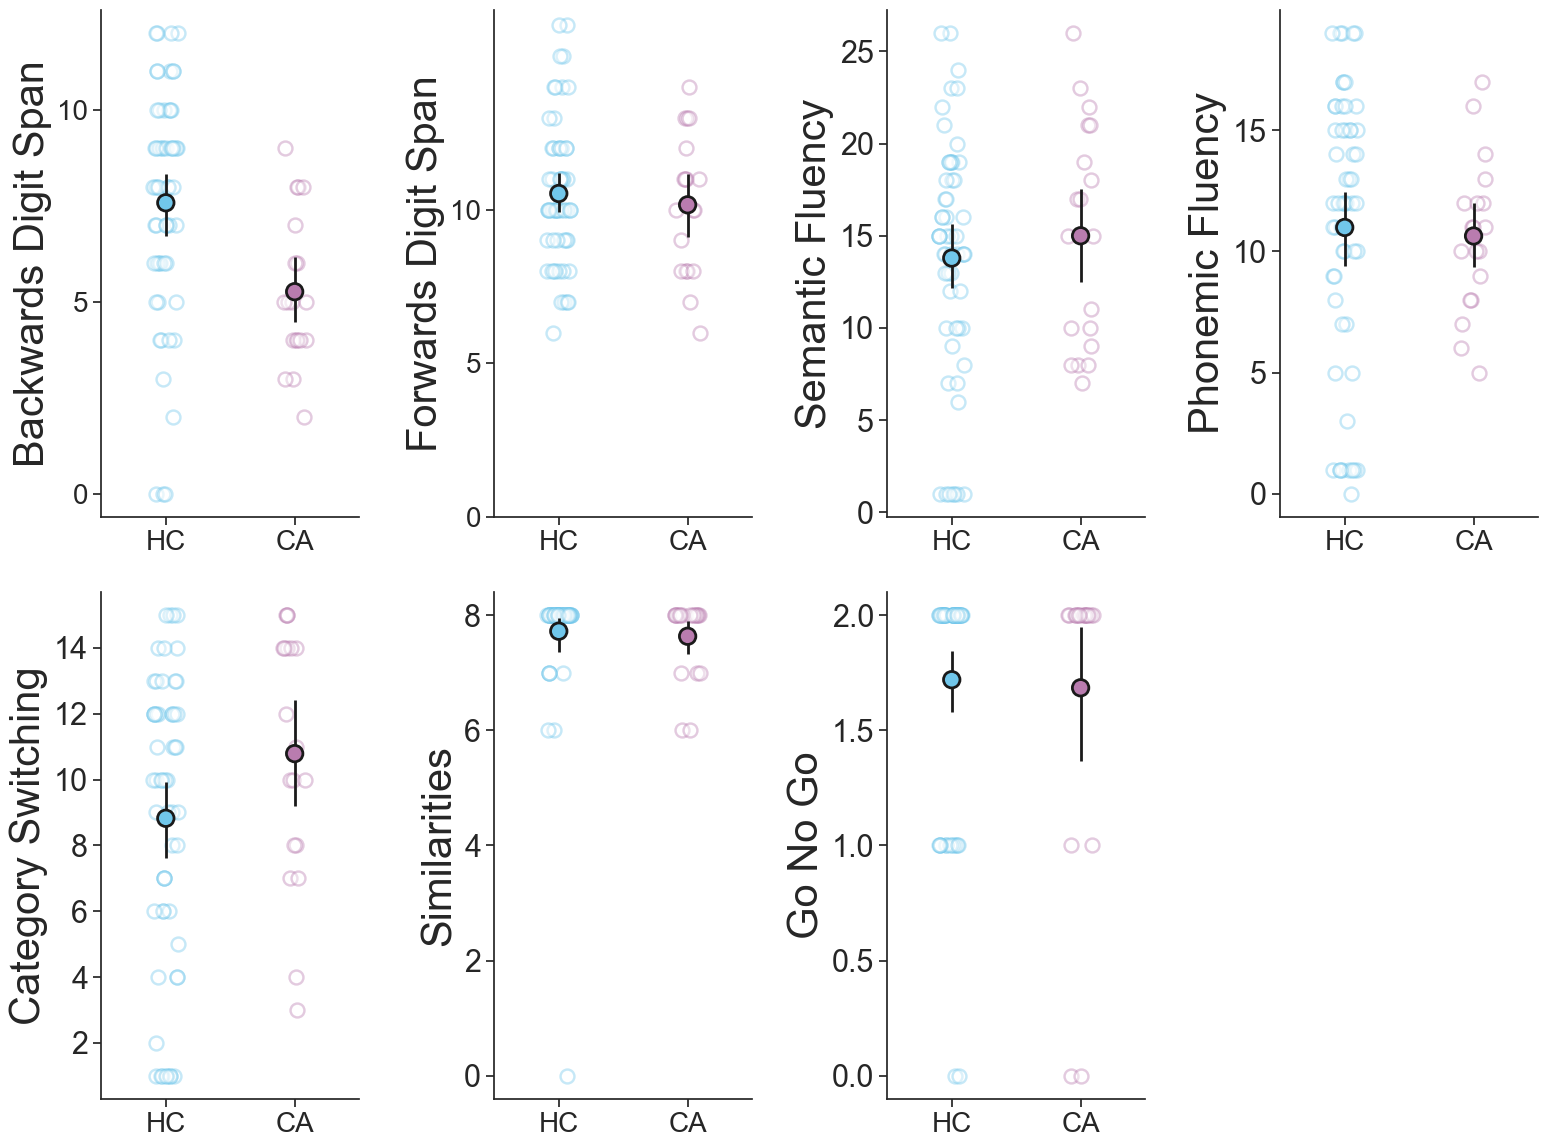

In [6]:
'''
This chunk plots supplementary figure 1.
'''

palette = ["#b97caf","#71c7eb"]

f, axes = plt.subplots(2,4,figsize=(16,12))
grp_order = ["CTRL","PAT"]
pal4 = [palette[1],palette[0]]
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax = axes[0,0]
  sns.pointplot(x="group",y="8_digitspan_bwd",data=scored_ccas,join=False,units="subject_id",
                color='k',ax=ax,scale=1.75,errwidth=2,order=grp_order)
  plt.setp(ax.collections, facecolor=pal4,zorder=100,linewidth=2)
  sns.stripplot(x="group",y="8_digitspan_bwd",data=scored_ccas,palette=palette,order=grp_order,s=10,ax=ax)
  plt.setp(ax.collections[1], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[0],alpha=0.4)
  plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[1],alpha=0.4)
  ax.set_ylabel("Backwards Digit Span",size=30)
  ax.set_xticklabels(["HC","CA"],size=20)
  ax.set_yticks([0,5,10])
  ax.set_yticklabels([0,5,10],size=20)
  ax.set_xlabel("")

  ax = axes[0,1]
  sns.pointplot(x="group",y="1_digitspan_fwd",data=scored_ccas,join=False,units="subject_id",
                color='k',ax=ax,scale=1.75,errwidth=2,order=grp_order)
  plt.setp(ax.collections, facecolor=pal4,zorder=100,linewidth=2)
  sns.stripplot(x="group",y="1_digitspan_fwd",data=scored_ccas,palette=palette,order=grp_order,s=10,ax=ax)
  plt.setp(ax.collections[1], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[0],alpha=0.4)
  plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[1],alpha=0.4)
  ax.set_ylabel("Forwards Digit Span",size=30)
  ax.set_xticklabels(["HC","CA"],size=20)
  ax.set_yticks([0,5,10])
  ax.set_yticklabels([0,5,10],size=20)
  ax.set_xlabel("")

  ax = axes[0,2]
  sns.pointplot(x="group",y="2_semantic_fluency",data=scored_ccas,join=False,units="subject_id",
                color='k',ax=ax,scale=1.75,errwidth=2,order=grp_order)
  plt.setp(ax.collections, facecolor=pal4,zorder=100,linewidth=2)
  sns.stripplot(x="group",y="2_semantic_fluency",data=scored_ccas,palette=palette,order=grp_order,s=10,ax=ax)
  plt.setp(ax.collections[1], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[0],alpha=0.4)
  plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[1],alpha=0.4)
  ax.set_ylabel("Semantic Fluency",size=30)
  ax.set_xticklabels(["HC","CA"],size=20)
  #ax.set_yticks([0,5,10])
  #ax.set_yticklabels([0,5,10],size=20)
  ax.set_xlabel("")

  ax = axes[0,3]
  sns.pointplot(x="group",y="3_phonemic_fluency",data=scored_ccas,join=False,units="subject_id",
                color='k',ax=ax,scale=1.75,errwidth=2,order=grp_order)
  plt.setp(ax.collections, facecolor=pal4,zorder=100,linewidth=2)
  sns.stripplot(x="group",y="3_phonemic_fluency",data=scored_ccas,palette=palette,order=grp_order,s=10,ax=ax)
  plt.setp(ax.collections[1], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[0],alpha=0.4)
  plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[1],alpha=0.4)
  ax.set_ylabel("Phonemic Fluency",size=30)
  ax.set_xticklabels(["HC","CA"],size=20)
  #ax.set_yticks([0,5,10])
  #ax.set_yticklabels([0,5,10],size=20)
  ax.set_xlabel("")

  ax = axes[1,0]
  sns.pointplot(x="group",y="4_category_switching",data=scored_ccas,join=False,units="subject_id",
                color='k',ax=ax,scale=1.75,errwidth=2,order=grp_order)
  plt.setp(ax.collections, facecolor=pal4,zorder=100,linewidth=2)
  sns.stripplot(x="group",y="4_category_switching",data=scored_ccas,palette=palette,order=grp_order,s=10,ax=ax)
  plt.setp(ax.collections[1], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[0],alpha=0.4)
  plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[1],alpha=0.4)
  ax.set_ylabel("Category Switching",size=30)
  ax.set_xticklabels(["HC","CA"],size=20)
  #ax.set_yticks([0,5,10])
  #ax.set_yticklabels([0,5,10],size=20)
  ax.set_xlabel("")

  ax = axes[1,1]
  sns.pointplot(x="group",y="5_similarity",data=scored_ccas,join=False,units="subject_id",
                color='k',ax=ax,scale=1.75,errwidth=2,order=grp_order)
  plt.setp(ax.collections, facecolor=pal4,zorder=100,linewidth=2)
  sns.stripplot(x="group",y="5_similarity",data=scored_ccas,palette=palette,order=grp_order,s=10,ax=ax)
  plt.setp(ax.collections[1], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[0],alpha=0.4)
  plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[1],alpha=0.4)
  ax.set_ylabel("Similarities",size=30)
  ax.set_xticklabels(["HC","CA"],size=20)
  #ax.set_yticks([0,5,10])
  #ax.set_yticklabels([0,5,10],size=20)
  ax.set_xlabel("")

  ax = axes[1,2]
  sns.pointplot(x="group",y="6_gonogo",data=scored_ccas,join=False,units="subject_id",
                color='k',ax=ax,scale=1.75,errwidth=2,order=grp_order)
  plt.setp(ax.collections, facecolor=pal4,zorder=100,linewidth=2)
  sns.stripplot(x="group",y="6_gonogo",data=scored_ccas,palette=palette,order=grp_order,s=10,ax=ax)
  plt.setp(ax.collections[1], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[0],alpha=0.4)
  plt.setp(ax.collections[2], facecolor="w",linewidth=1.75,zorder=0,edgecolor=pal4[1],alpha=0.4)
  ax.set_ylabel("Go No Go",size=30)
  ax.set_xticklabels(["HC","CA"],size=20)
  #ax.set_yticks([0,5,10])
  #ax.set_yticklabels([0,5,10],size=20)
  ax.set_xlabel("")

  sns.despine()

  axes[1,3].set_xticklabels([])
  axes[1,3].set_xticks([])
  axes[1,3].set_yticklabels([])
  axes[1,3].set_yticks([])
  axes[1,3].get_xaxis().set_visible(False)
  axes[1,3].get_yaxis().set_visible(False)
  axes[1,3].spines["left"].set_visible(False)
  axes[1,3].spines["bottom"].set_visible(False)

plt.tight_layout();

plt.savefig(os.path.join(paper_dir,"code/figures/figure4.pdf"))

In [ ]:
# Determine which data comes from MCI patients and which does not
mci = []
for i, row in rm_data["patient"].iterrows():
  if row.subject_id in [1,2,5,10,11,14,15]:
    mci.append("MCI")
  else:
    mci.append("No MCI")
rm_data["patient"]["mci"] = mci
mci = []
for i, row in rm_elpd_diffs.iterrows():
  if row.subject_id in ['001','002','005','010','011','014','015']:
    if row.group == "PAT":
      mci.append("MCI")
    else:
      mci.append("HC")
  else:
    if row.group == "PAT":
      mci.append("No MCI")
    else:
      mci.append("HC")
rm_elpd_diffs["mci"] = mci

diag_palette = ["#71c7eb","#66c2a5","#fc8d62"]

suppFig1 = plt.figure(figsize=(14,12),constrained_layout=True)
gs = suppFig1.add_gridspec(2,1)

gs0 = gs[0].subgridspec(1,3,width_ratios=[3,4,3],wspace=0.4)
ax1 = suppFig1.add_subplot(gs0[0,0])
ax4 = suppFig1.add_subplot(gs0[0,1])
ax6 = suppFig1.add_subplot(gs0[0,2])

gs1 = gs[1].subgridspec(1,1,wspace=0.2)
ax2 = suppFig1.add_subplot(gs1[0,0])

diag_order1 = ["HC","No MCI","MCI"]
diag_order = ["No MCI","MCI"]

ax = ax1
rm_data["control"]["mci"] = "HC"
diag_means1 = pd.concat([rm_data["control"],rm_data["patient"]]).groupby(["mci","subject_id"]).accuracy.mean().reset_index()
diag_means = rm_data["patient"].groupby(["mci","subject_id"]).accuracy.mean().reset_index()
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  sns.pointplot(x="mci",y="accuracy",data=diag_means1,join=False,units="subject_id",
                color='k',ax=ax,scale=1.5,errwidth=2,order=diag_order1)
  plt.setp(ax.collections, facecolor=diag_palette,zorder=100,linewidth=2)
  for i,d in enumerate(diag_order):
    if d == "MCI":
      dm = diag_means[diag_means.mci == d]
    else:
      dm = diag_means[diag_means.mci != "MCI"]
    #ax.scatter([i+1]*len(dm),dm.accuracy,color=diag_palette[i+1],s=90,zorder=0,alpha=1)
    ax.scatter(np.random.normal(i+1,0.1,len(dm)),dm.accuracy,color=diag_palette[i+1],s=80,facecolor="w",zorder=0,linewidth=1.75,alpha=0.4)

ax.set_ylim(0,1)
ax.set_ylabel("Prop. Correct Choices",size=20)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,0.25,0.5,0.75,1],size=14)
ax.set_xlabel("",size=20)
ax.set_xticklabels(diag_order1,size=14)
ax.set_xticks(range(0,3)) #2
ax.plot((-1,3),(0.5,0.5),'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

line_axes = [ax2,ax2]
for i,d in enumerate(diag_order):
  ax = line_axes[i]
  with plt.rc_context({'lines.solid_capstyle': 'butt'}):
    ci_plot=95
    sns.lineplot(x="trial_binned",y="accuracy",data=rm_data["ideal"],color="gray",
                 ax=ax,linewidth=5,ci=None,style=True, dashes=[(2,2)], legend=False)
    sns.lineplot(x="trial_binned",y="accuracy",data=rm_data["control"],color=diag_palette[0],
                 ax=ax,linewidth=5,ci=ci_plot)
    if d == "MCI":
     dm = rm_data["patient"][rm_data["patient"].mci == d]
    else:
     dm = rm_data["patient"][rm_data["patient"].mci != "MCI"]
    sns.lineplot(x="trial_binned",y="accuracy",data=dm,
                 color=diag_palette[i+1],ax=ax,linewidth=5,ci=ci_plot)
    ax.set_ylim(0,1.1)
    ax.set_ylabel("")
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels([0,0.5,1],size=14)
    ax.set_xlim(0,19)
    ax.plot((-1,19),(0.5,0.5),'k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(["0-10","50-60","100-110","150-160","190-200"],size=14)
    ax.set_xlabel("Trials (10/Bin)",size=20)
    ax.set_xticks([0,5,10,15,19])
    ax.set_ylabel("Prop. Corrected Choices",size=20)
    #ax.set_title(d,size=20)

    ax.plot((0.25,1.25),(0.2,0.2),color="gray",linewidth=5,linestyle='--')
    ax.plot((0.25,1.25),(0.15,0.15),color=diag_palette[0],linewidth=5)
    ax.plot((0.25,1.25),(0.1,0.1),color=diag_palette[1],linewidth=5)
    ax.plot((0.25,1.25),(0.05,0.05),color=diag_palette[2],linewidth=5)
    ax.text(1.35,0.185,'Bayes',fontsize=14)
    ax.text(1.35,0.135,'HC',fontsize=14)
    ax.text(1.35,0.085,'No MCI',fontsize=14)
    ax.text(1.35,0.035,'MCI',fontsize=14)


ax = ax4
for i,d in enumerate(diag_order):
  with plt.rc_context({'lines.solid_capstyle': 'butt'}):
    ax.plot((0,1),(0.5,0.5),'k')
    ci_plot=95
    sns.regplot(x="pFReward1",y="accuracy",data=rm_data['ideal'],ax=ax,order=2,color='gray',marker="",ci=None,line_kws={"linestyle":"--","linewidth":4})
    sns.regplot(x="pFReward1",y="accuracy",data=rm_data['control'],ax=ax,order=2,color=diag_palette[0],marker="",ci=ci_plot)
    if d == "MCI":
      dm = rm_data["patient"][rm_data["patient"].mci == d]
    else:
      dm = rm_data["patient"][rm_data["patient"].mci != "MCI"]
    sns.regplot(x="pFReward1",y="accuracy",data=dm,
                ax=ax,order=2,color=diag_palette[i+1],line_kws={"linewidth":4},ci=ci_plot,marker="")
ax.set_ylabel("Prop. Correct Choices",size=20)
ax.set_xlabel("P(F Rewarded for Cue 1)",size=20)
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_xticklabels([0,0.25,0.5,0.75,1],size=14)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,0.25,0.5,0.75,1],size=14)
ax.set_ylim(0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((0.025,0.145),(0.2,0.2),color="gray",linewidth=5,linestyle='--')
  ax.plot((0.025,0.145),(0.15,0.15),color=diag_palette[0],linewidth=5)
  ax.plot((0.025,0.145),(0.1,0.1),color=diag_palette[1],linewidth=5)
  ax.plot((0.025,0.145),(0.05,0.05),color=diag_palette[2],linewidth=5)
  ax.text(0.16,0.185,'Bayes',fontsize=14)
  ax.text(0.16,0.135,'HC',fontsize=14)
  ax.text(0.16,0.085,'No MCI',fontsize=14)
  ax.text(0.16,0.035,'MCI',fontsize=14)

ax = ax6
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  sns.pointplot(x="mci",y="elpd_diff",data=rm_elpd_diffs,join=False,units="subject_id",
                color='k',ax=ax,scale=1.5,errwidth=2,order=diag_order1)
  plt.setp(ax.collections, facecolor=diag_palette,zorder=100,linewidth=2)
  for i,d in enumerate(diag_order):
    if d == "MCI":
      elpd_diag = rm_elpd_diffs[rm_elpd_diffs.mci == d].elpd_diff
    else:
      elpd_diag = rm_elpd_diffs[rm_elpd_diffs.mci == "No MCI"].elpd_diff
    #ax.scatter([i+1]*len(elpd_diag),elpd_diag,color=diag_palette[i+1],s=90,zorder=0,alpha=1)
    ax.scatter(np.random.normal(i+1,0.1,len(elpd_diag)),elpd_diag,color=diag_palette[i+1],s=80,facecolor="w",zorder=0,linewidth=1.75,alpha=0.4)

ax.plot((-0.4,2.4),(0,0),'k')
ax.set_title("ELPD",size=20)
ax.set_ylabel("Q Learner - Biased Resp.",size=20)
ax.set_xticklabels(diag_order1,size=14)
ax.set_xticks(range(0,3))
ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels([0,20,40,60,80,100],size=14)
ax.set_xlabel("")
ax.set_xlim(-0.4,2.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gcf().text(0, 0.965, "A", fontsize=32)
plt.gcf().text(0.3, 0.965, "B", fontsize=32)
plt.gcf().text(0.665, 0.965, "C", fontsize=32)
plt.gcf().text(0, 0.48, "D", fontsize=32)

plt.tight_layout();
plt.savefig(os.path.join(paper_dir,"code/figures/Figure2-1.pdf"))


In [ ]:
# Determine which data comes from MSA patients and which does not
msa = []
for i, row in rm_data["patient"].iterrows():
  if row.subject_id in [4,6,10]:
    msa.append("MSA")
  else:
    msa.append("Other")
rm_data["patient"]["msa"] = msa
msa = []
for i, row in rm_elpd_diffs.iterrows():
  if row.subject_id in ['004','006','010']:
    if row.group == "PAT":
      msa.append("MSA")
    else:
      msa.append("HC")
  else:
    if row.group == "PAT":
      msa.append("Other")
    else:
      msa.append("HC")
rm_elpd_diffs["msa"] = msa

diag_palette = ["#71c7eb",sns.color_palette("Set1")[1],sns.color_palette("Set1")[2]]

suppFig1 = plt.figure(figsize=(14,12),constrained_layout=True)
gs = suppFig1.add_gridspec(2,1)

gs0 = gs[0].subgridspec(1,3,width_ratios=[3,4,3],wspace=0.4)
ax1 = suppFig1.add_subplot(gs0[0,0])
ax4 = suppFig1.add_subplot(gs0[0,1])
ax6 = suppFig1.add_subplot(gs0[0,2])

gs1 = gs[1].subgridspec(1,1,wspace=0.2)
ax2 = suppFig1.add_subplot(gs1[0,0])

diag_order1 = ["HC","Other","MSA"]
diag_order = ["Other","MSA"]

ax = ax1
rm_data["control"]["msa"] = "HC"
diag_means1 = pd.concat([rm_data["control"],rm_data["patient"]]).groupby(["msa","subject_id"]).accuracy.mean().reset_index()
diag_means = rm_data["patient"].groupby(["diagnosis_short","subject_id"]).accuracy.mean().reset_index()
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  sns.pointplot(x="msa",y="accuracy",data=diag_means1,join=False,units="subject_id",
                color='k',ax=ax,scale=1.5,errwidth=2,order=["HC","Other"])
  plt.setp(ax.collections, facecolor=diag_palette,zorder=100,linewidth=2)
  for i,d in enumerate(diag_order):
    if d == "MSA":
      dm = diag_means[diag_means.diagnosis_short == d]
      alph = 1
    else:
      dm = diag_means[diag_means.diagnosis_short != "MSA"]
      alph = 0.4
    ax.scatter(np.random.normal(i+1,0.1,len(dm)),dm.accuracy,color=diag_palette[i+1],s=80,facecolor="w",zorder=0,linewidth=1.75,alpha=alph)

ax.set_ylim(0,1)
ax.set_ylabel("Prop. Correct Choices",size=20)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,0.25,0.5,0.75,1],size=14)
ax.set_xlabel("",size=20)
ax.set_xticks(range(0,3)) #2
ax.set_xticklabels(diag_order1,size=14)
ax.plot((-1,3),(0.5,0.5),'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

line_axes = [ax2,ax2]
for i,d in enumerate(diag_order):
  ax = line_axes[i]
  with plt.rc_context({'lines.solid_capstyle': 'butt'}):
    ci_plot=95
    sns.lineplot(x="trial_binned",y="accuracy",data=rm_data["ideal"],color="gray",
                 ax=ax,linewidth=5,ci=None,style=True, dashes=[(2,2)], legend=False)
    sns.lineplot(x="trial_binned",y="accuracy",data=rm_data["control"],color=diag_palette[0],
                 ax=ax,linewidth=5,ci=ci_plot)
    if d == "MSA":
     dm = rm_data["patient"][rm_data["patient"].diagnosis_short == d]
     pats = dm.subject_id.unique()
     sns.lineplot(x="trial_binned",y="accuracy",data=dm[dm.subject_id == pats[0]],
                  color=diag_palette[i+1],ax=ax,linewidth=2,ci=None)
     sns.lineplot(x="trial_binned",y="accuracy",data=dm[dm.subject_id == pats[1]],
                  color=diag_palette[i+1],ax=ax,linewidth=2,ci=None)
    else:
     dm = rm_data["patient"][rm_data["patient"].diagnosis_short != "MSA"]
     sns.lineplot(x="trial_binned",y="accuracy",data=dm,
                  color=diag_palette[i+1],ax=ax,linewidth=5,ci=ci_plot)
    ax.set_ylim(0,1.1)
    ax.set_ylabel("")
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels([0,0.5,1],size=14)
    ax.set_xlim(0,19)
    ax.plot((-1,19),(0.5,0.5),'k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(["0-10","50-60","100-110","150-160","190-200"],size=14)
    ax.set_xlabel("Trials (10/Bin)",size=20)
    ax.set_xticks([0,5,10,15,19])
    ax.set_ylabel("Prop. Corrected Choices",size=20)
    #ax.set_title(d,size=20)

    ax.plot((0.25,1.25),(0.2,0.2),color="gray",linewidth=5,linestyle='--')
    ax.plot((0.25,1.25),(0.15,0.15),color=diag_palette[0],linewidth=5)
    ax.plot((0.25,1.25),(0.1,0.1),color=diag_palette[1],linewidth=5)
    ax.plot((0.25,1.25),(0.05,0.05),color=diag_palette[2],linewidth=5)
    ax.text(1.35,0.185,'Bayes',fontsize=14)
    ax.text(1.35,0.135,'HC',fontsize=14)
    ax.text(1.35,0.085,'Other',fontsize=14)
    ax.text(1.35,0.035,'MSA',fontsize=14)


ax = ax4
for i,d in enumerate(diag_order):
  with plt.rc_context({'lines.solid_capstyle': 'butt'}):
    ax.plot((0,1),(0.5,0.5),'k')
    ci_plot=95
    sns.regplot(x="pFReward1",y="accuracy",data=rm_data['ideal'],ax=ax,order=2,color='gray',marker="",ci=None,line_kws={"linestyle":"--","linewidth":4})
    sns.regplot(x="pFReward1",y="accuracy",data=rm_data['control'],ax=ax,order=2,color=diag_palette[0],marker="",ci=ci_plot)
    if d == "MSA":
      dm = rm_data["patient"][rm_data["patient"].diagnosis_short == d]
      pats = dm.subject_id.unique()
      sns.regplot(x="pFReward1",y="accuracy",data=dm[dm.subject_id == pats[0]],
                  ax=ax,order=2,color=diag_palette[i+1],line_kws={"linewidth":2},ci=None,marker="")
      sns.regplot(x="pFReward1",y="accuracy",data=dm[dm.subject_id == pats[1]],
                  ax=ax,order=2,color=diag_palette[i+1],line_kws={"linewidth":2},ci=None,marker="")
    else:
      dm = rm_data["patient"][rm_data["patient"].diagnosis_short != "MSA"]
      sns.regplot(x="pFReward1",y="accuracy",data=dm,
                  ax=ax,order=2,color=diag_palette[i+1],line_kws={"linewidth":4},ci=ci_plot,marker="")
ax.set_ylabel("Prop. Correct Choices",size=20)
ax.set_xlabel("P(F Rewarded for Cue 1)",size=20)
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_xticklabels([0,0.25,0.5,0.75,1],size=14)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,0.25,0.5,0.75,1],size=14)
ax.set_ylim(0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((0.025,0.145),(0.2,0.2),color="gray",linewidth=5,linestyle='--')
  ax.plot((0.025,0.145),(0.15,0.15),color=diag_palette[0],linewidth=5)
  ax.plot((0.025,0.145),(0.1,0.1),color=diag_palette[1],linewidth=5)
  ax.plot((0.025,0.145),(0.05,0.05),color=diag_palette[2],linewidth=5)
  ax.text(0.16,0.185,'Bayes',fontsize=14)
  ax.text(0.16,0.135,'HC',fontsize=14)
  ax.text(0.16,0.085,'Other',fontsize=14)
  ax.text(0.16,0.035,'MSA',fontsize=14)

ax = ax6
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  sns.pointplot(x="msa",y="elpd_diff",data=rm_elpd_diffs,join=False,units="subject_id",
                color='k',ax=ax,scale=1.5,errwidth=2,order=["HC","Other"])
  plt.setp(ax.collections, facecolor=[diag_palette[0],diag_palette[1]],zorder=100,linewidth=2)
  for i,d in enumerate(diag_order):
    if d == "MSA":
      elpd_diag = rm_elpd_diffs[rm_elpd_diffs.msa == d].elpd_diff
      alph = 1
    else:
      elpd_diag = rm_elpd_diffs[rm_elpd_diffs.msa == "Other"].elpd_diff
      alph = 0.4
    ax.scatter(np.random.normal(i+1,0.1,len(elpd_diag)),elpd_diag,color=diag_palette[i+1],s=80,facecolor="w",zorder=0,linewidth=1.75,alpha=alph)

ax.plot((-0.4,2.4),(0,0),'k')
ax.set_title("ELPD",size=20)
ax.set_ylabel("Q Learner - Biased Resp.",size=20)
ax.set_xticks(range(0,3))
ax.set_xticklabels(diag_order1,size=14)
ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels([0,20,40,60,80,100],size=14)
ax.set_xlabel("")
ax.set_xlim(-0.4,2.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gcf().text(0, 0.965, "A", fontsize=32)
plt.gcf().text(0.3, 0.965, "B", fontsize=32)
plt.gcf().text(0.665, 0.965, "C", fontsize=32)
plt.gcf().text(0, 0.48, "D", fontsize=32)

plt.tight_layout();
plt.savefig(os.path.join(paper_dir,"code/figures/Figure2-2.pdf"))


In [ ]:
# Determine which data comes from MCI patients and which does not
mci = []
for i, row in lrd_pat.iterrows():
  if row.subject_id in [1,2,5,10,11,14,15]:
    mci.append("MCI")
  else:
    mci.append("No MCI")
lrd_pat["mci"] = mci
mci = []
for i, row in card_data["patient"].iterrows():
  if row.subject_id in [1,2,5,10,11,14,15]:
    mci.append("MCI")
  else:
    mci.append("No MCI")
card_data["patient"]["mci"] = mci
mci = []
for i, row in pat_diags.iterrows():
  if row.subject_id in [1,2,5,10,11,14,15]:
    mci.append("MCI")
  else:
    mci.append("No MCI")
pat_diags["mci"] = mci

diag_palette = ["#71c7eb","#66c2a5","#fc8d62"]

suppFig2 = plt.figure(figsize=(12,12),constrained_layout=True)
gs = suppFig2.add_gridspec(2,1)

#
gs0 = gs[0].subgridspec(1,2,width_ratios=[1,1],wspace=0.25)
ax1 = suppFig2.add_subplot(gs0[0,0])
ax2 = suppFig2.add_subplot(gs0[0,1])
#
gs1 = gs[1].subgridspec(1,4,width_ratios=[1.2,1.2,1.2,1.2],wspace=0.4)
ax3 = suppFig2.add_subplot(gs1[0,0])
ax4 = suppFig2.add_subplot(gs1[0,1])
ax5 = suppFig2.add_subplot(gs1[0,2])
ax6 = suppFig2.add_subplot(gs1[0,3])

#diag_palette = ["#71c7eb",sns.color_palette("Set1")[1],sns.color_palette("Set1")[2]]

diag_order1 = ["HC","No MCI","MCI"]
diag_order = ["No MCI","MCI"]

ax = ax1
lrd_ctrl["mci"] = "HC"
lrd_diags = lrd_pat.merge(pat_diags[["diagnosis_short","subject_id"]],on="subject_id")
lrd_diags1 = pd.concat([lrd_ctrl,lrd_pat]).groupby(["mci","subject_id"]).lucky_chosen.mean().reset_index()
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((-3,3),(0.5,0.5),'k')
  ax.plot((0,0),(0.1,0.9),'k')
  sns.lineplot(x="time_point",y="lucky_chosen",data=lrd_ideal,ax=ax,color="gray",linewidth=5,ci=None,style=True, dashes=[(2,2)], legend=False)
  for i,d in enumerate(diag_order):
    ci_plot = 95
    if d == "MCI":
      lrdd = lrd_diags[lrd_diags.mci == d]
    else:
      lrdd = lrd_diags[lrd_diags.mci != "MCI"]
    sns.lineplot(x="time_point",y="lucky_chosen",data=lrdd,ax=ax,color=diag_palette[i+1],linewidth=5,ci=ci_plot,style=True, legend=False)
    sns.lineplot(x="time_point",y="lucky_chosen",data=lrd_ctrl,ax=ax,color=diag_palette[0],linewidth=5,ci=ci_plot,style=True, legend=False)

ax.set_ylim(0.1,0.9)
ax.set_yticks([0.2,0.4,0.6,0.8])
ax.set_yticklabels([0.2,0.4,0.6,0.8],size=16)
ax.set_ylabel("P(Choose Lucky Deck)",size=20)
ax.set_xlim(-3,3)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels([-3,-2,-1,0,1,2,3],size=16)
ax.set_xlabel("Trials Around Reversal",size=20)

card_diags = card_data["patient"].merge(pat_diags[["mci","subject_id"]],on=["subject_id","mci"])

ax = ax2
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((-0.25,5.25),(0.5,0.5),'k')
  sns.pointplot(x="old_value",y="old_chosen",data=card_data["ideal"],ax=ax,color="gray",ci=None,linestyles=["--"],scale=1.7,errwidth=3)
  sns.pointplot(x="old_value",y="old_chosen",data=card_data["control"],ax=ax,color=diag_palette[0],scale=1.7,errwidth=3,ci=ci_plot)
  for i,d in enumerate(diag_order):
    ci_plot = 95
    if d == "MCI":
      cdd = card_diags[card_diags.mci == d]
    else:
      cdd = card_diags[card_diags.mci != "MCI"]
    sns.pointplot(x="old_value",y="old_chosen",data=cdd,ax=ax,color=diag_palette[i+1],scale=1.7,errwidth=3,ci=ci_plot)

  ax.plot((3.35,4),(0.14,0.14),diag_palette[0],linewidth=5)
  ax.plot((3.35,4),(0.09,0.09),diag_palette[1],linewidth=5)
  ax.plot((3.35,4),(0.04,0.04),diag_palette[2],linewidth=5)
  ax.plot((3.35,4),(-0.01,-0.01),"gray",linestyle='--',linewidth=5)
  ax.text(4.05,0.125,diag_order1[0],fontsize=14)
  ax.text(4.05,0.075,diag_order1[1],fontsize=14)
  ax.text(4.05,0.025,diag_order1[2],fontsize=14)
  ax.text(4.05,-0.025,'Bayes+Ep',fontsize=14)


plt.setp(ax.collections, facecolor="w",zorder=100,alpha=1) #,linewidth=0.75,edgecolor="k"
ax.set_ylim(-0.05,1.05)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],size=16)
ax.set_ylabel("P(Choose Old Object)",size=20)
ax.set_xlim(-0.25,5.25)
ax.set_xticklabels([0,20,40,60,80,100],size=16)
ax.set_xlabel("Old Object Value (¢)",size=20)

pat_fit_params = full_hybrid_rws[full_hybrid_rws.group == "PAT"]
ctrl_fit_params = full_hybrid_rws[full_hybrid_rws.group == "CTRL"]
ctrl_fit_params["mci"] = "HC"
pat_fit_params["subject_id"] = pat_fit_params.subject_id.astype(int)
diag_fit_params = pat_fit_params.merge(pat_diags[["mci","subject_id"]],on="subject_id")
diag_fit_params = pd.concat([diag_fit_params,ctrl_fit_params]).reset_index()

ticklabsize=16
axlabsize=20
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
 ax = ax3
 sns.pointplot(x="mci",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[1]"])],hue="mci",
               ax=ax,join=False,hue_order=diag_order1,scale=1.75,errwidth=2,color="k",dodge=0.5,order=diag_order1)
 g1 = sns.stripplot(x="mci",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[1]"])],hue="mci",dodge=True,
               palette=diag_palette,order=diag_order1,hue_order=diag_order1,ax=ax,s=10,jitter=0.25)
 g1.legend_.remove()
 ax.plot((-1,3),(0,0),'k',linewidth=1)
 ax.set_xticklabels(diag_order1,size=axlabsize,rotation=90)
 ax.set_xlabel("")
 ax.set_ylabel("Beta Estimate",size=axlabsize)
 ax.set_title("Deck Value",size=axlabsize)
 ax.set_ylim(-5,14)
 ax.set_yticks([-5,0,5,10])
 ax.set_xlim((-1,3))
 ax.set_yticklabels([-5,0,5,10],size=ticklabsize)
 plt.setp(ax.collections[0], facecolor=diag_palette[0],zorder=100,linewidth=2)
 plt.setp(ax.collections[1], facecolor=diag_palette[1],zorder=100,linewidth=2)
 plt.setp(ax.collections[2], facecolor=diag_palette[2],zorder=100,linewidth=2)
 plt.setp(ax.collections[3:5], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[0],alpha=0.4)
 plt.setp(ax.collections[5:10], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[1],alpha=0.4)
 plt.setp(ax.collections[10:15], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[2],alpha=0.4)

 with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax = ax4

  sns.pointplot(x="mci",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[2]"])],hue="mci",
                ax=ax,join=False,hue_order=diag_order1,scale=1.75,errwidth=2,color="k",dodge=0.5,order=diag_order1)
  g1 = sns.stripplot(x="mci",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[2]"])],hue="mci",dodge=True,
                palette=diag_palette,order=diag_order1,hue_order=diag_order1,ax=ax,s=10,jitter=0.25)
  g1.legend_.remove()
  ax.plot((-1,3),(0,0),'k',linewidth=1)
  ax.set_xticklabels(diag_order1,size=axlabsize,rotation=90)
  ax.set_xlabel("")
  ax.set_ylabel("Beta Estimate",size=axlabsize)
  ax.set_title("Old Value",size=axlabsize)
  ax.set_yticks([-2,0,2,4])
  ax.set_yticklabels([-2,0,2,4],size=ticklabsize)
  ax.set_xlim((-1,3))
  ax.set_ylim(-2,5.5)
  plt.setp(ax.collections[0], facecolor=diag_palette[0],zorder=100,linewidth=2)
  plt.setp(ax.collections[1], facecolor=diag_palette[1],zorder=100,linewidth=2)
  plt.setp(ax.collections[2], facecolor=diag_palette[2],zorder=100,linewidth=2)
  plt.setp(ax.collections[3:5], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[0],alpha=0.4)
  plt.setp(ax.collections[5:10], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[1],alpha=0.4)
  plt.setp(ax.collections[10:15], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[2],alpha=0.4)


 with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax = ax5

  sns.pointplot(x="mci",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[3]"])],hue="mci",
                ax=ax,join=False,hue_order=diag_order1,scale=1.75,errwidth=2,color="k",dodge=0.5,order=diag_order1)
  g1 = sns.stripplot(x="mci",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[3]"])],hue="mci",dodge=True,
                palette=diag_palette,order=diag_order1,hue_order=diag_order1,ax=ax,s=10,jitter=0.25)
  g1.legend_.remove()
  ax.plot((-1,3),(0,0),'k',linewidth=1)
  ax.set_xticklabels(diag_order1,size=axlabsize,rotation=90)
  ax.set_xlabel("")
  ax.set_ylabel("Beta Estimate",size=axlabsize)
  ax.set_title("Old Bias",size=axlabsize)
  ax.set_yticks([-2,0,2,4])
  ax.set_yticklabels([-2,0,2,4],size=ticklabsize)
  ax.set_xlim((-1,3))
  ax.set_ylim(-2,5.5)
  plt.setp(ax.collections[0], facecolor=diag_palette[0],zorder=100,linewidth=2)
  plt.setp(ax.collections[1], facecolor=diag_palette[1],zorder=100,linewidth=2)
  plt.setp(ax.collections[2], facecolor=diag_palette[2],zorder=100,linewidth=2)
  plt.setp(ax.collections[3:5], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[0],alpha=0.4)
  plt.setp(ax.collections[5:10], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[1],alpha=0.4)
  plt.setp(ax.collections[10:15], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[2],alpha=0.4)


ctrl_dprimes = dprimes[dprimes.group == "PAT"]
ctrl_dprimes["mci"] = "HC"
diag_dprimes = dprimes[dprimes.group == "PAT"].merge(pat_diags[["mci","subject_id"]],on="subject_id")
diag_dprimes = pd.concat([ctrl_dprimes,diag_dprimes]).reset_index(drop=True)
ax = ax6
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((-1,3),(0,0),'k',linewidth=1)

  sns.pointplot(x="mci",y="dprime",data=diag_dprimes,hue="mci",
                ax=ax,join=False,hue_order=diag_order1,scale=1.75,errwidth=2,color="k",dodge=0.5,order=diag_order1)
  g1 = sns.stripplot(x="mci",y="dprime",data=diag_dprimes,hue="mci",dodge=True,
                palette=diag_palette,order=diag_order1,hue_order=diag_order1,ax=ax,s=10,jitter=0.25)
  g1.legend_.remove()

ax.set_ylabel("Recognition Memory (d')",size=20)
ax.set_xticklabels(diag_order1,size=20,rotation=90)
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels([-1,0,1,2,3],size=16)
ax.set_ylim(-1.5,4)
ax.set_xlabel("")
ax.set_xlim((-1,3))
plt.setp(ax.collections[0], facecolor=diag_palette[0],zorder=100,linewidth=2)
plt.setp(ax.collections[1], facecolor=diag_palette[1],zorder=100,linewidth=2)
plt.setp(ax.collections[2], facecolor=diag_palette[2],zorder=100,linewidth=2)
plt.setp(ax.collections[3:5], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[0],alpha=0.4)
plt.setp(ax.collections[5:10], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[1],alpha=0.4)
plt.setp(ax.collections[10:15], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[2],alpha=0.4)


plt.gcf().text(0, 0.965, "A", fontsize=32)
plt.gcf().text(0.48, 0.965, "B", fontsize=32)
plt.gcf().text(0, 0.5, "C", fontsize=32)
plt.gcf().text(0.73, 0.5, "D", fontsize=32)

plt.tight_layout()
sns.despine();
plt.savefig(os.path.join(paper_dir,"code/figures/Figure3-1.pdf"))


In [ ]:
# Determine which data comes from MSA patients and which does not
MSA = []
for i, row in lrd_pat.iterrows():
  if row.subject_id in [4,6,10]:
    MSA.append("MSA")
  else:
    MSA.append("Other")
lrd_pat["diagnosis_short"] = MSA
MSA = []
for i, row in card_data["patient"].iterrows():
  if row.subject_id in [4,6,10]:
    MSA.append("MSA")
  else:
    MSA.append("Other")
card_data["patient"]["diagnosis_short"] = MSA
MSA = []
for i, row in pat_diags.iterrows():
  if row.subject_id in [4,6,10]:
    MSA.append("MSA")
  else:
    MSA.append("Other")
pat_diags["diagnosis_short"] = MSA

diag_palette = [sns.color_palette("Set1")[1],sns.color_palette("Set1")[2]]

suppFig2 = plt.figure(figsize=(12,12),constrained_layout=True)
gs = suppFig2.add_gridspec(2,1)

#
gs0 = gs[0].subgridspec(1,2,width_ratios=[1,1],wspace=0.25)
ax1 = suppFig2.add_subplot(gs0[0,0])
ax2 = suppFig2.add_subplot(gs0[0,1])
#
gs1 = gs[1].subgridspec(1,4,width_ratios=[1.2,1.2,1.2,1.2],wspace=0.4)
ax3 = suppFig2.add_subplot(gs1[0,0])
ax4 = suppFig2.add_subplot(gs1[0,1])
ax5 = suppFig2.add_subplot(gs1[0,2])
ax6 = suppFig2.add_subplot(gs1[0,3])

diag_palette = ["#71c7eb",sns.color_palette("Set1")[1],sns.color_palette("Set1")[2]]

diag_order1 = ["HC","Other","MSA"]
diag_order = ["Other","MSA"]

ax = ax1
lrd_ctrl["diagnosis_short"] = "HC"
lrd_diags = lrd_pat.merge(pat_diags[["subject_id"]],on="subject_id")

lrd_diags1 = pd.concat([lrd_ctrl,lrd_pat]).groupby(["diagnosis_short","subject_id"]).lucky_chosen.mean().reset_index()
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((-3,3),(0.5,0.5),'k')
  ax.plot((0,0),(0.1,0.9),'k')
  sns.lineplot(x="time_point",y="lucky_chosen",data=lrd_ideal,ax=ax,color="gray",linewidth=5,ci=None,style=True, dashes=[(2,2)], legend=False)
  for i,d in enumerate(diag_order):
    ci_plot = 95
    if d == "MSA":
      lrdd = lrd_diags[lrd_diags.diagnosis_short == d]
      pats = lrdd.subject_id.unique()
      sns.lineplot(x="time_point",y="lucky_chosen",data=lrdd[lrdd.subject_id == pats[0]],ax=ax,color=diag_palette[i+1],linewidth=2,ci=None,style=True, legend=False)
      sns.lineplot(x="time_point",y="lucky_chosen",data=lrdd[lrdd.subject_id == pats[1]],ax=ax,color=diag_palette[i+1],linewidth=2,ci=None,style=True, legend=False)
      sns.lineplot(x="time_point",y="lucky_chosen",data=lrdd[lrdd.subject_id == pats[2]],ax=ax,color=diag_palette[i+1],linewidth=2,ci=None,style=True, legend=False)
    else:
      lrdd = lrd_diags[lrd_diags.diagnosis_short != "MSA"]
      sns.lineplot(x="time_point",y="lucky_chosen",data=lrdd,ax=ax,color=diag_palette[i+1],linewidth=5,ci=ci_plot,style=True, legend=False)
    sns.lineplot(x="time_point",y="lucky_chosen",data=lrd_ctrl,ax=ax,color=diag_palette[0],linewidth=5,ci=ci_plot,style=True, legend=False)

ax.set_ylim(0.1,0.9)
ax.set_yticks([0.2,0.4,0.6,0.8])
ax.set_yticklabels([0.2,0.4,0.6,0.8],size=16)
ax.set_ylabel("P(Choose Lucky Deck)",size=20)
ax.set_xlim(-3,3)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels([-3,-2,-1,0,1,2,3],size=16)
ax.set_xlabel("Trials Around Reversal",size=20)

card_diags = card_data["patient"].merge(pat_diags[["diagnosis_short","subject_id"]],on=["subject_id","diagnosis_short"])

ax = ax2
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((-0.25,5.25),(0.5,0.5),'k')
  sns.pointplot(x="old_value",y="old_chosen",data=card_data["ideal"],ax=ax,color="gray",ci=None,linestyles=["--"],scale=1.7,errwidth=3)
  sns.pointplot(x="old_value",y="old_chosen",data=card_data["control"],ax=ax,color=diag_palette[0],scale=1.7,errwidth=3,ci=ci_plot)
  for i,d in enumerate(diag_order):
    ci_plot = 95
    if d == "MSA":
      cdd = card_diags[card_diags.diagnosis_short == d]
      pats = cdd.subject_id.unique()
      sns.pointplot(x="old_value",y="old_chosen",data=cdd[cdd.subject_id == pats[0]],ax=ax,color=diag_palette[i+1],scale=1,errwidth=3,ci=None)
      sns.pointplot(x="old_value",y="old_chosen",data=cdd[cdd.subject_id == pats[1]],ax=ax,color=diag_palette[i+1],scale=1,errwidth=3,ci=None)
      sns.pointplot(x="old_value",y="old_chosen",data=cdd[cdd.subject_id == pats[2]],ax=ax,color=diag_palette[i+1],scale=1,errwidth=3,ci=None)
    else:
      cdd = card_diags[card_diags.diagnosis_short != "MSA"]
      sns.pointplot(x="old_value",y="old_chosen",data=cdd,ax=ax,color=diag_palette[i+1],scale=1.7,errwidth=3,ci=ci_plot)

  ax.plot((3.35,4),(0.14,0.14),color=diag_palette[0],linewidth=5)
  ax.plot((3.35,4),(0.09,0.09),color=diag_palette[1],linewidth=5)
  ax.plot((3.35,4),(0.04,0.04),color=diag_palette[2],linewidth=5)
  ax.plot((3.35,4),(-0.01,-0.01),color="gray",linestyle='--',linewidth=5)
  ax.text(4.05,0.125,diag_order1[0],fontsize=14)
  ax.text(4.05,0.075,diag_order1[1],fontsize=14)
  ax.text(4.05,0.025,diag_order1[2],fontsize=14)
  ax.text(4.05,-0.025,'Bayes+Ep',fontsize=14)


plt.setp(ax.collections, facecolor="w",zorder=100,alpha=1) #,linewidth=0.75,edgecolor="k"
ax.set_ylim(-0.05,1.05)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],size=16)
ax.set_ylabel("P(Choose Old Object)",size=20)
ax.set_xlim(-0.25,5.25)
ax.set_xticklabels([0,20,40,60,80,100],size=16)
ax.set_xlabel("Old Object Value (¢)",size=20)

pat_fit_params = full_hybrid_rws[full_hybrid_rws.group == "PAT"]
ctrl_fit_params = full_hybrid_rws[full_hybrid_rws.group == "CTRL"]
ctrl_fit_params["diagnosis_short"] = "HC"
pat_fit_params["subject_id"] = pat_fit_params.subject_id.astype(int)
diag_fit_params = pat_fit_params.merge(pat_diags[["diagnosis_short","subject_id"]],on="subject_id")
diag_fit_params = pd.concat([diag_fit_params,ctrl_fit_params]).reset_index()

ticklabsize=16
axlabsize=20
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
 ax = ax3
 sns.pointplot(x="diagnosis_short",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[1]"])],hue="diagnosis_short",
               ax=ax,join=False,hue_order=["HC","Other"],scale=1.75,errwidth=2,color="k",dodge=0.5,order=["HC","Other"])
 g1 = sns.stripplot(x="diagnosis_short",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[1]"])],hue="diagnosis_short",dodge=True,
               palette=diag_palette,order=diag_order1,hue_order=diag_order1,ax=ax,s=10,jitter=0.25)
 g1.legend_.remove()
 ax.plot((-1,3),(0,0),'k',linewidth=1)
 ax.set_xticklabels(diag_order1,size=axlabsize,rotation=90)
 ax.set_xlabel("")
 ax.set_ylabel("Beta Estimate",size=axlabsize)
 ax.set_title("Deck Value",size=axlabsize)
 ax.set_ylim(-5,14)
 ax.set_yticks([-5,0,5,10])
 ax.set_xlim((-1,3))
 ax.set_yticklabels([-5,0,5,10],size=ticklabsize)
 plt.setp(ax.collections[0], facecolor=diag_palette[0],zorder=100,linewidth=2)
 plt.setp(ax.collections[1], facecolor=diag_palette[1],zorder=100,linewidth=2)
 plt.setp(ax.collections[2:5], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[0],alpha=0.4)
 plt.setp(ax.collections[5:10], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[1],alpha=0.4)
 plt.setp(ax.collections[10:15], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[2],alpha=1)

 with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax = ax4

  sns.pointplot(x="diagnosis_short",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[2]"])],hue="diagnosis_short",
                ax=ax,join=False,hue_order=["HC","Other"],scale=1.75,errwidth=2,color="k",dodge=0.5,order=["HC","Other"])
  g1 = sns.stripplot(x="diagnosis_short",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[2]"])],hue="diagnosis_short",dodge=True,
                palette=diag_palette,order=diag_order1,hue_order=diag_order1,ax=ax,s=10,jitter=0.25)
  g1.legend_.remove()
  ax.plot((-1,3),(0,0),'k',linewidth=1)
  ax.set_xticklabels(diag_order1,size=axlabsize,rotation=90)
  ax.set_xlabel("")
  ax.set_ylabel("Beta Estimate",size=axlabsize)
  ax.set_title("Old Value",size=axlabsize)
  ax.set_yticks([-2,0,2,4])
  ax.set_yticklabels([-2,0,2,4],size=ticklabsize)
  ax.set_xlim((-1,3))
  ax.set_ylim(-2,5.5)
  plt.setp(ax.collections[0], facecolor=diag_palette[0],zorder=100,linewidth=2)
  plt.setp(ax.collections[1], facecolor=diag_palette[1],zorder=100,linewidth=2)
  plt.setp(ax.collections[2:5], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[0],alpha=0.4)
  plt.setp(ax.collections[5:10], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[1],alpha=0.4)
  plt.setp(ax.collections[10:15], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[2],alpha=1)


 with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax = ax5

  sns.pointplot(x="diagnosis_short",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[3]"])],hue="diagnosis_short",
                ax=ax,join=False,hue_order=["HC","Other"],scale=1.75,errwidth=2,color="k",dodge=0.5,order=["HC","Other"])
  g1 = sns.stripplot(x="diagnosis_short",y="mean",data=diag_fit_params[diag_fit_params.param.isin(["beta[3]"])],hue="diagnosis_short",dodge=True,
                palette=diag_palette,order=diag_order1,hue_order=diag_order1,ax=ax,s=10,jitter=0.25)
  g1.legend_.remove()
  ax.plot((-1,3),(0,0),'k',linewidth=1)
  ax.set_xticklabels(diag_order1,size=axlabsize,rotation=90)
  ax.set_xlabel("")
  ax.set_ylabel("Beta Estimate",size=axlabsize)
  ax.set_title("Old Bias",size=axlabsize)
  ax.set_yticks([-2,0,2,4])
  ax.set_yticklabels([-2,0,2,4],size=ticklabsize)
  ax.set_xlim((-1,3))
  ax.set_ylim(-2,5.5)
  plt.setp(ax.collections[0], facecolor=diag_palette[0],zorder=100,linewidth=2)
  plt.setp(ax.collections[1], facecolor=diag_palette[1],zorder=100,linewidth=2)
  plt.setp(ax.collections[2:5], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[0],alpha=0.4)
  plt.setp(ax.collections[5:10], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[1],alpha=0.4)
  plt.setp(ax.collections[10:15], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[2],alpha=1)


ctrl_dprimes = dprimes[dprimes.group == "PAT"]
ctrl_dprimes["diagnosis_short"] = "HC"
diag_dprimes = dprimes[dprimes.group == "PAT"].merge(pat_diags[["diagnosis_short","subject_id"]],on="subject_id")
diag_dprimes = pd.concat([ctrl_dprimes,diag_dprimes]).reset_index(drop=True)
ax = ax6
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
  ax.plot((-1,3),(0,0),'k',linewidth=1)

  sns.pointplot(x="diagnosis_short",y="dprime",data=diag_dprimes,hue="diagnosis_short",
                ax=ax,join=False,hue_order=["HC","Other"],scale=1.75,errwidth=2,color="k",dodge=0.5,order=["HC","Other"])
  g1 = sns.stripplot(x="diagnosis_short",y="dprime",data=diag_dprimes,hue="diagnosis_short",dodge=True,
                palette=diag_palette,order=diag_order1,hue_order=diag_order1,ax=ax,s=10,jitter=0.25)
  g1.legend_.remove()

ax.set_ylabel("Recognition Memory (d')",size=20)
ax.set_xticklabels(diag_order1,size=20,rotation=90)
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels([-1,0,1,2,3],size=16)
ax.set_ylim(-1.5,4)
ax.set_xlabel("")
ax.set_xlim((-1,3))
plt.setp(ax.collections[0], facecolor=diag_palette[0],zorder=100,linewidth=2)
plt.setp(ax.collections[1], facecolor=diag_palette[1],zorder=100,linewidth=2)
plt.setp(ax.collections[2:5], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[0],alpha=0.4)
plt.setp(ax.collections[5:10], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[1],alpha=0.4)
plt.setp(ax.collections[10:15], facecolor="w",linewidth=1.75,zorder=0,edgecolor=diag_palette[2],alpha=1)


plt.gcf().text(0, 0.965, "A", fontsize=32)
plt.gcf().text(0.48, 0.965, "B", fontsize=32)
plt.gcf().text(0, 0.5, "C", fontsize=32)
plt.gcf().text(0.73, 0.5, "D", fontsize=32)

plt.tight_layout()
sns.despine();
plt.savefig(os.path.join(paper_dir,"code/figures/Figure3-2.pdf"))
